In [13]:
import numpy as np
import xarray as xr
import pandas as pd
import scipy
import sys 
import warnings
warnings.filterwarnings('ignore')
import time as timer
start_all = timer.time()

In [14]:
dataf ="/Volumes/ESA_F4R/era/" 
datao ="/Volumes/ESA_F4R/ed_prepare/" 
datap ="/Users/ellendyer/Library/Mobile Documents/com~apple~CloudDocs/1SHARED_WORK/Work/3_ESA_GRANT/MODEL/plots/era/"

In [15]:
#For selection and plotting
YR = 1990
time_bnds = (str(YR)+'-01-01',str(YR)+'-12-31')
lon_bnds, lat_bnds = (7, 33), (13,-16)
lon_bnds_f, lat_bnds_f = (8, 32), (-15,12) 
p_bnds = (30000,100000)

**Read in ERA5 data on pressure levels (hourly timesteps in fortnightly files)**
- *fortnightly files currently run from 1994-2024*
- resampled to monthly MS timestep
- shum multiplied by 1000 to convert from kg/kg --> g/kg
- pressure levels are divided by 100 to convert from Pa to hPa (only for fortnightly files)
- sort data by descending pressure levels (only for fortnightly files)


**Input file units:**
- plev - pa
- q - kg/kg
- u - m/s
- v - m/s

In [16]:
start = timer.time()
from functools import partial
def _preprocess_pres(x, lon_bnds, lat_bnds, p_bnds):
    return x.sel(lon=slice(*lon_bnds), lat=slice(*lat_bnds),
                 plev=slice(*p_bnds),drop=True)
partial_func_pres = partial(_preprocess_pres, lon_bnds=lon_bnds, lat_bnds=lat_bnds, p_bnds=p_bnds)

#Reading in pressure level variables from ERA5
ds_era_pres = xr.open_mfdataset(dataf+"era5/pressure_levels/era5_pressure_level_variables_central_africa_"+str(YR)+"*.nc",
                                drop_variables=['r','t','w'],
                                preprocess=partial_func_pres,parallel=True).resample(time='MS').mean(dim='time').load()
ds_era_pres = ds_era_pres.rename({'plev':'level','q':'Shum','u':'Uwnd','v':'Vwnd'})
ds_era_pres['Shum'] = 1000.0*ds_era_pres['Shum']
ds_era_pres['level'] = ds_era_pres['level']/100.0  
ds_era_pres = ds_era_pres.sortby('level', ascending=False) 
end = timer.time()
length = end - start
print("ERA5 pressure level data read in took ", length, "seconds")

ERA5 pressure level data read in took  1003.0606100559235 seconds


**Read in ERA5 land data (hourly in monthly files)**
- selecting hour 23 (0-23) of Prec and Evap because of how ERA5 Land variables are accumulated (https://confluence.ecmwf.int/pages/viewpage.action?pageId=197702790 - https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation#ERA5Land:datadocumentation-accumulationsAccumulations)
- prec is multiplied by 1000 to convert from m to mm
- evap is multiplied by -1000 to convert from m to mm and upward fluxes in land model are considered negative
- Prec, Evap, and Psfc are then resampled to MS monthly and also interpolated to coarser pressure level grid

**Input file units:**
- tp - m
- e - m (-)
- sp - pa

In [17]:
start = timer.time()
from functools import partial
def _preprocess_land(x, lon_bnds, lat_bnds):
    x = x.sel(longitude=slice(*lon_bnds), latitude=slice(*lat_bnds),drop=True)
    return x
partial_func_land = partial(_preprocess_land, lon_bnds=lon_bnds, lat_bnds=lat_bnds)

#Reading in surface variables from ERA5 Land
ds_era_land = xr.open_mfdataset("/Volumes/ESA_F4R/era/era5_land/era5_land_variables_central_africa_"+str(YR)+"*.nc",
                                drop_variables=['expver','number','pev','ssr','t2m'],
                                preprocess=partial_func_land,parallel=True).load()
ds_era_land = ds_era_land.rename({'valid_time':'time','latitude':'lat',
                                  'longitude':'lon','tp':'Prec','e':'Evap','sp':'Psfc'})
ds_era_land = ds_era_land.interp(lat=ds_era_pres['lat'],lon=ds_era_pres['lon'],method='linear',kwargs={"fill_value": "extrapolate"})
Prec = ds_era_land['Prec'].where(ds_era_land['time.hour']==23,drop=True)*1000.0
Evap = ds_era_land['Evap'].where(ds_era_land['time.hour']==23,drop=True)*-1000.0
Prec = Prec.resample(time='MS').mean(dim='time') 
Evap = Evap.resample(time='MS').mean(dim='time')
Psfc = ds_era_land['Psfc'].resample(time='MS').mean(dim='time')/100.0
ds_era_land.close()
end = timer.time()
length = end - start
print("ERA5 land data read in took ", length, "seconds")

ERA5 land data read in took  465.29733204841614 seconds


**Merging all input datasets into one dataset for recyling code called ds**
- close both input datasets
- sort everything so latitude is south to north
- transpose dimensions so they run (lon,lat,level,time) as in recycling code
- save input ds to file

In [18]:
start = timer.time()
ds = xr.merge([ds_era_pres,Prec,Evap,Psfc]) 
ds_era_pres.close()
ds = ds.sortby('lat', ascending=True)
ds = ds.sel(lat=slice(*lat_bnds_f),lon=slice(*lon_bnds_f))
ds = ds.transpose("lon", "lat", "level", "time",missing_dims='ignore')
ds.to_netcdf(datao+"erads_"+str(YR)+".nc", mode='w', format='NETCDF4', engine='netcdf4')
end = timer.time()
length = end - start
print("Merging and dataset output took ", length, "seconds")

Merging and dataset output took  1.5412890911102295 seconds


**Integrate zonal and meridional moisture flux**
- ***To do:*** do this with hourly data to test difference in rho

In [19]:
#Prepping datasets near surface for recycling
import bulk_recycling_model.numerical_integration

# Integrate 10^-3 Shum Uwnd dp
# Because the integration limits are from high pressure to low pressure, we need to invert the sign.
integrand = -1 * 1e-3 * ds["Shum"] * ds["Uwnd"]
Fx = bulk_recycling_model.numerical_integration.integrate_with_extrapolation(integrand, ds["Psfc"])
# Units: mb x m/s

# Integrate 10^-3 Shum Vwnd dp
# Because the integration limits are from high pressure to low pressure, we need to invert the sign.
integrand = -1 * 1e-3 * ds["Shum"] * ds["Vwnd"]
Fy = bulk_recycling_model.numerical_integration.integrate_with_extrapolation(integrand, ds["Psfc"])
# Units: mb x m/s

IndexError: index 0 is out of bounds for axis 0 with size 0

**Prepare scaled data for recycling code**
- Evaporation and moisture fluxes


In [ ]:
# Prepare and scale the data
from bulk_recycling_model import preprocess
from bulk_recycling_model.axis import Axis
from bulk_recycling_model.scaling import Scaling, UnitSystem

# degrees
L = ds.coords["lon"].max().item() - ds.coords["lon"].min().item()
# convert to meters
L = L * 111e3 * np.cos(np.deg2rad(ds.coords["lat"].mean().item()))
dx = L / ds.sizes["lon"]

# lon axis
lon_axis = Axis(
    ds.coords["lon"].min().item(),
    ds.coords["lon"].diff("lon").mean().item(),
    ds.sizes["lon"],
)

# degrees
H = ds.coords["lat"].values[-1] - ds.coords["lat"].values[0]
# convert to meters
H = H * 111e3
dy = H / ds.sizes["lat"]

# lat axis
lat_axis = Axis(
    ds.coords["lat"].min().item(),
    ds.coords["lat"].diff("lat").mean().item(),
    ds.sizes["lat"],
)

print(f"{L = :.2e} m")
print(f"{dx = :.2e} m")
print(f"{H = :.2e} m")
print(f"{dy = :.2e} m")

# make a scaling object to convert between unit systems
scaling = Scaling(H)

dx = scaling.distance.convert(dx, UnitSystem.SI, UnitSystem.scaled)
dy = scaling.distance.convert(dy, UnitSystem.SI, UnitSystem.scaled)
print(f"{dx = :.2e} scaled")
print(f"{dy = :.2e} scaled")

# convert Fx and Fy to scaled units
Fx = scaling.water_vapor_flux.convert(Fx.values, UnitSystem.natural, UnitSystem.scaled)
Fy = scaling.water_vapor_flux.convert(Fy.values, UnitSystem.natural, UnitSystem.scaled)

# convert E to scaled units
#print('pre-scaled',ds['Evap'])
E = scaling.evaporation.convert(ds["Evap"].values, UnitSystem.natural, UnitSystem.scaled)

L = 1.66e+06 m
dx = 2.73e+04 m
H = 1.66e+06 m
dy = 2.73e+04 m
dx = 1.64e-02 scaled
dy = 1.64e-02 scaled


**Run recycling model for each timestep**
- Create recycling output array based on the shape of one of the surface input files: evap 
- Translate evap and fluxes to secondary grid
- Calculate modeled precipitation
- Plot scaled input variables (evap and fluxes)
- Run through each timestep in the input files and calculate recycling ratio at each timestep across domain
- Plot rho and convergence metric for each timestep

INFO:bulk_recycling_model.main:Converged in 284 iterations and 0:00:02.503672


0 1990-01-01T00:00:00.000000000
284


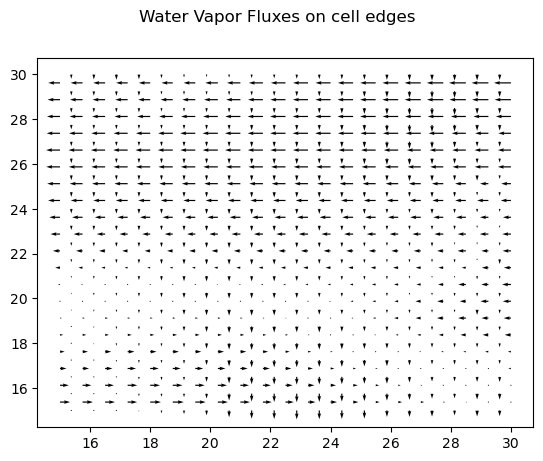

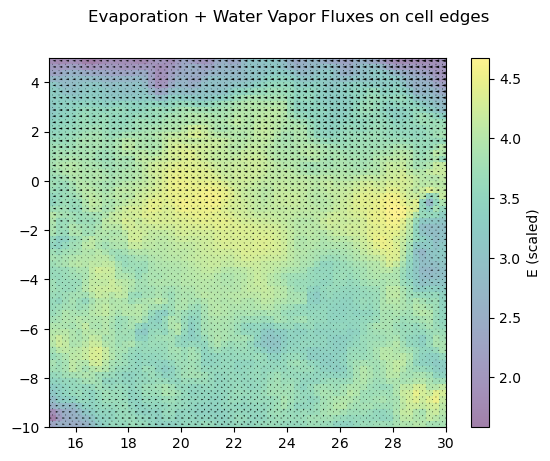

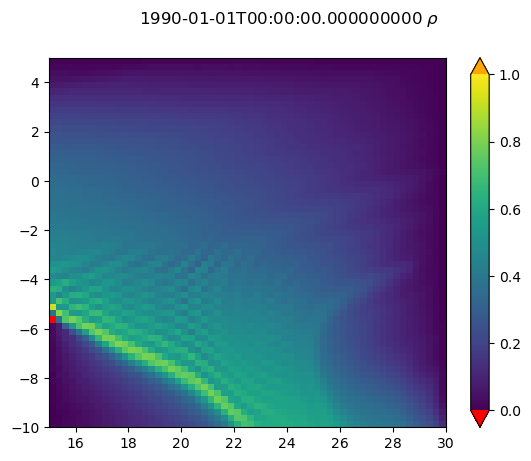

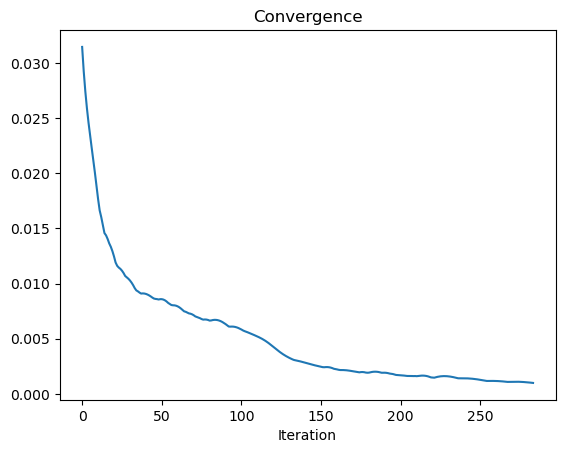

INFO:bulk_recycling_model.main:Converged in 297 iterations and 0:00:02.606529


1 1990-02-01T00:00:00.000000000
297


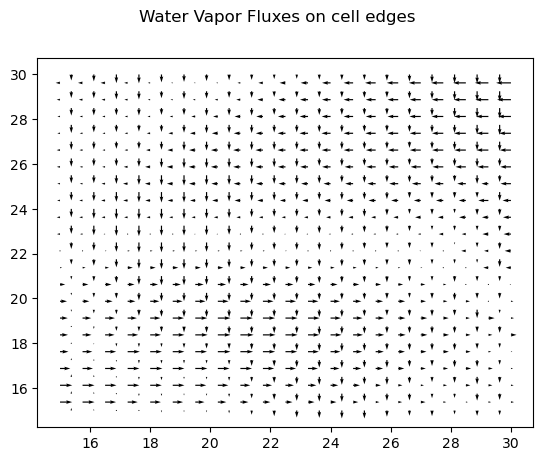

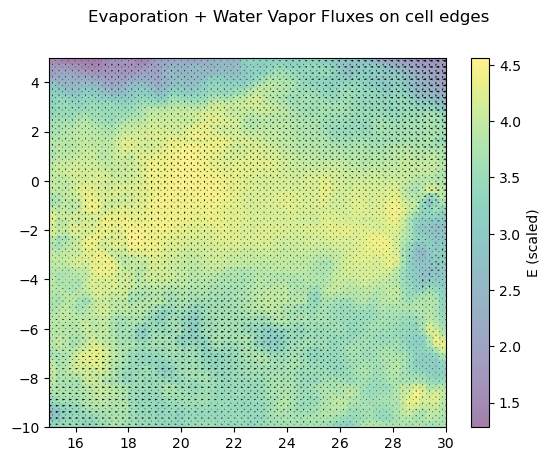

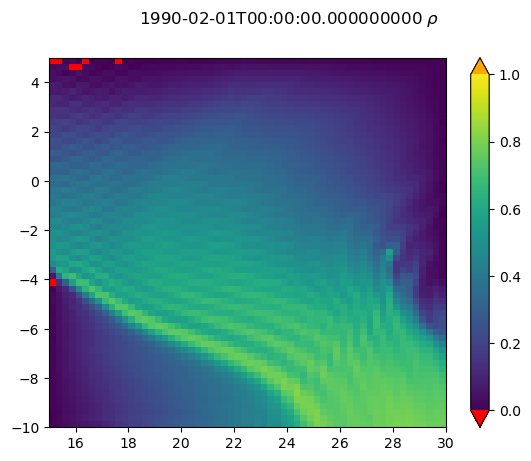

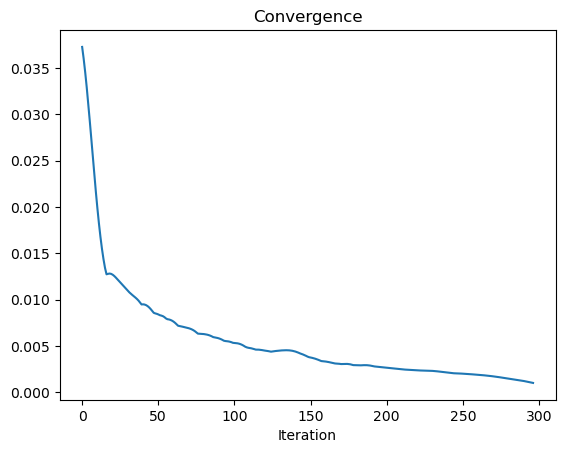

INFO:bulk_recycling_model.main:Converged in 232 iterations and 0:00:02.030332


2 1990-03-01T00:00:00.000000000
232


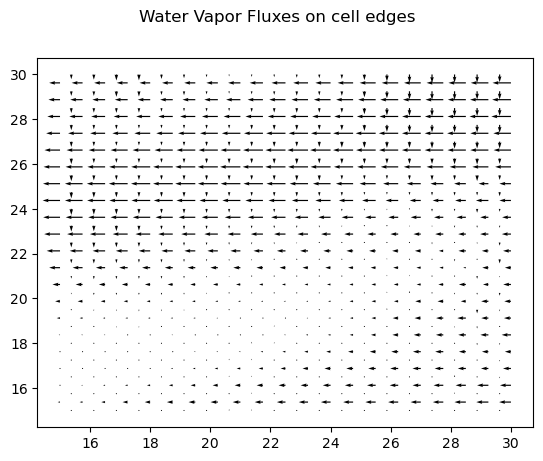

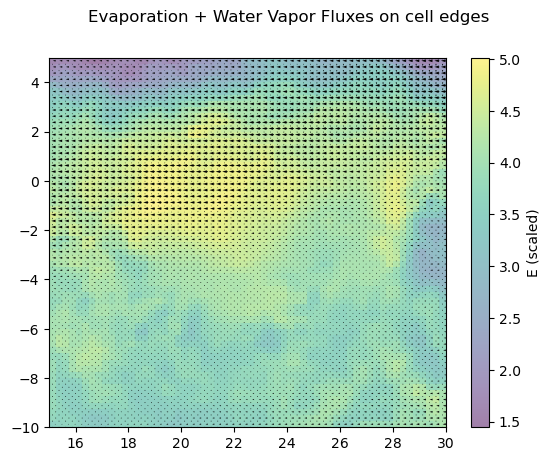

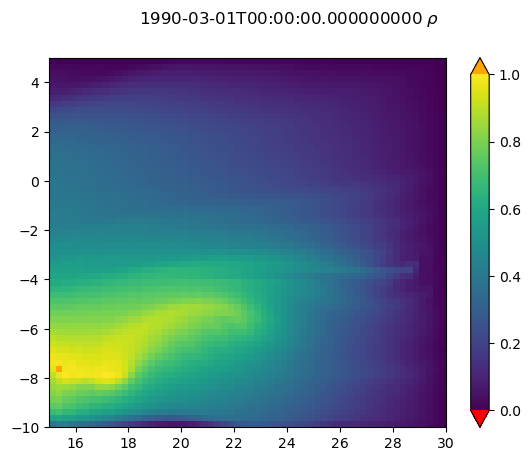

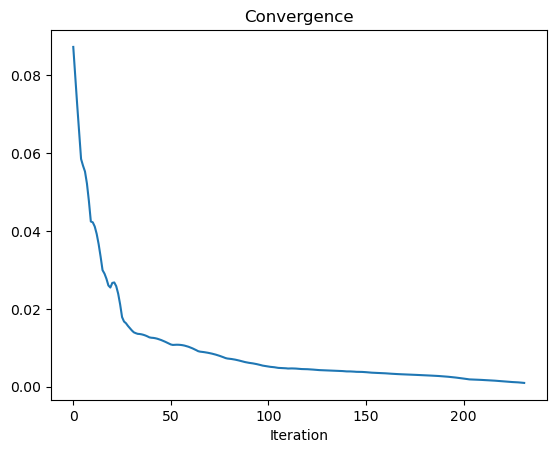

INFO:bulk_recycling_model.main:Converged in 250 iterations and 0:00:02.360677


3 1990-04-01T00:00:00.000000000
250


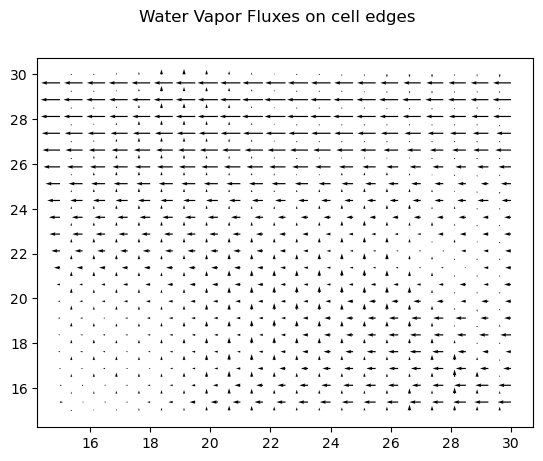

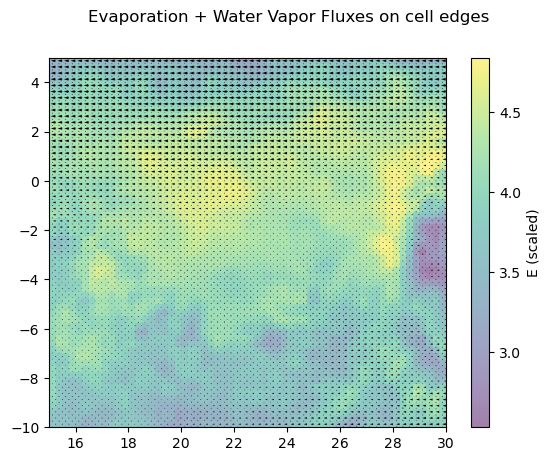

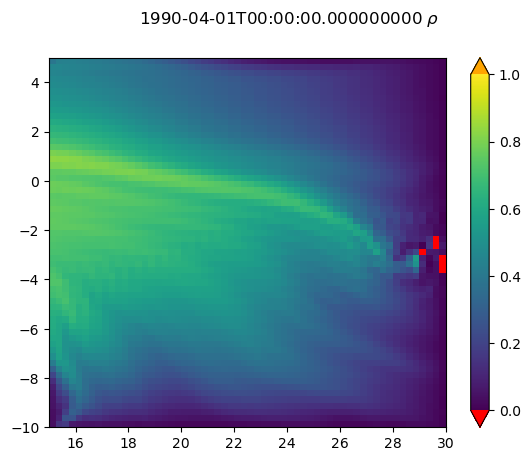

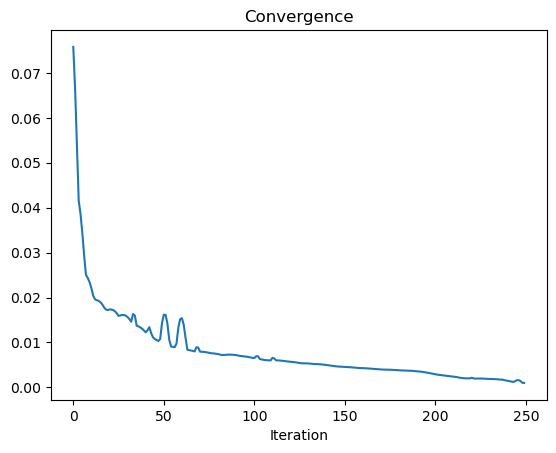

INFO:bulk_recycling_model.main:Converged in 237 iterations and 0:00:02.121534


4 1990-05-01T00:00:00.000000000
237


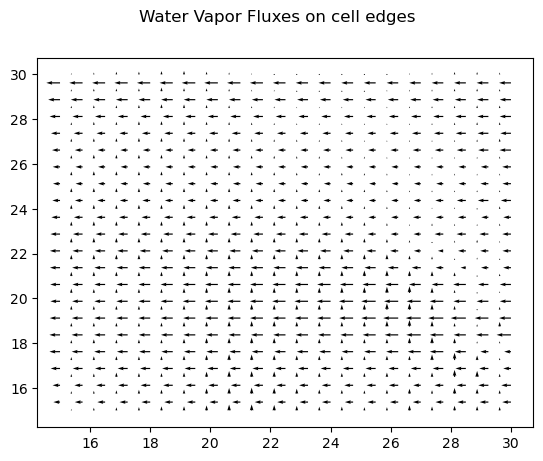

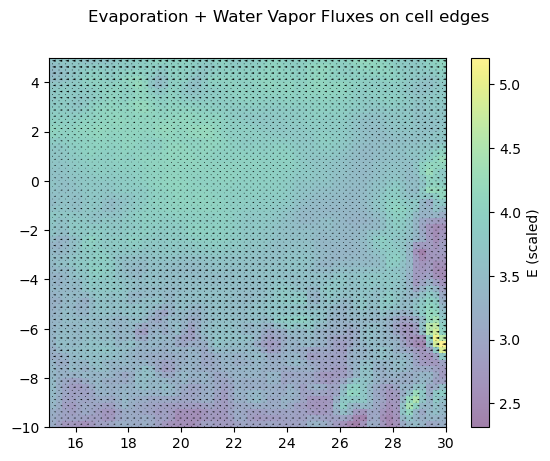

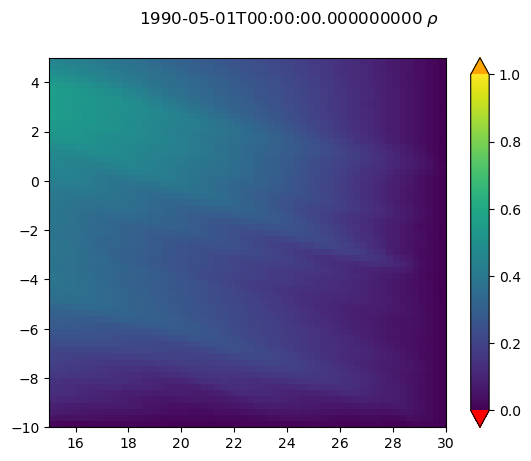

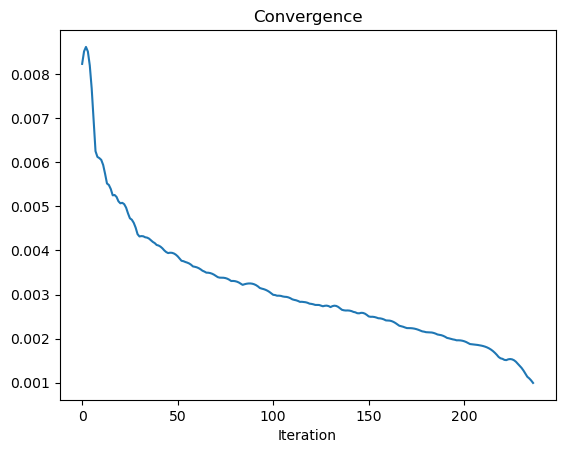

5 1990-06-01T00:00:00.000000000
500


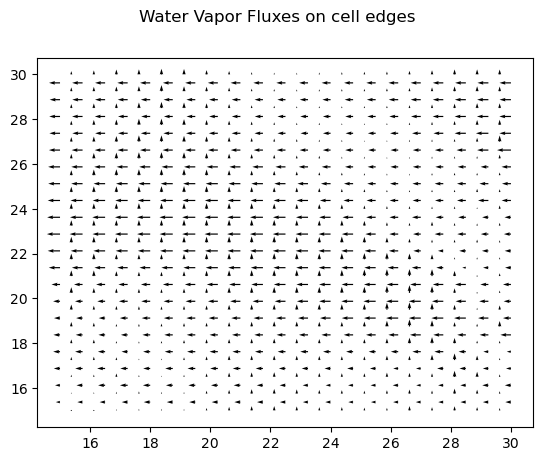

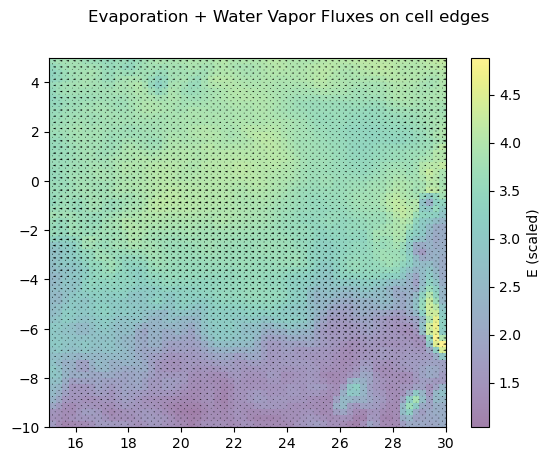

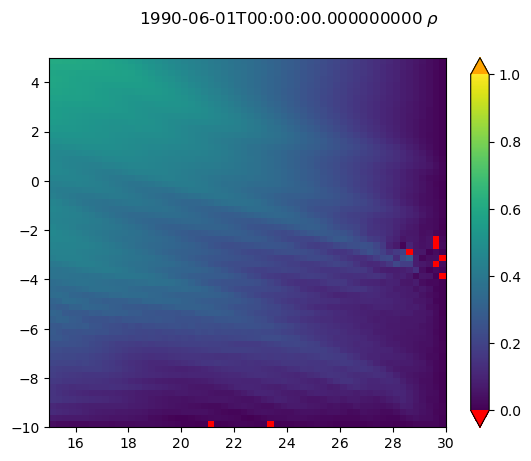

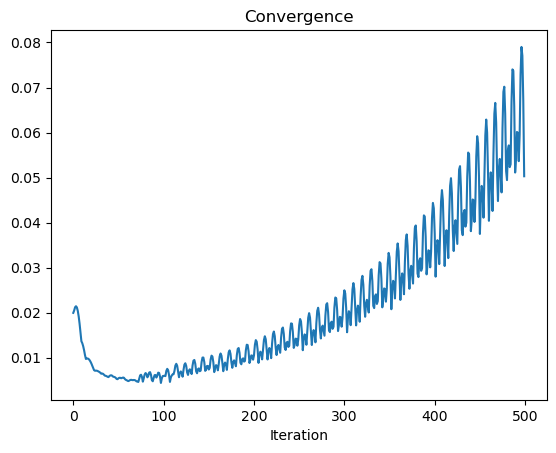

INFO:bulk_recycling_model.main:Converged in 272 iterations and 0:00:02.400850


6 1990-07-01T00:00:00.000000000
272


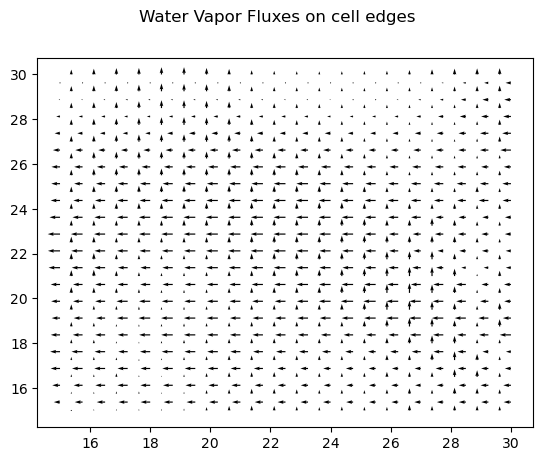

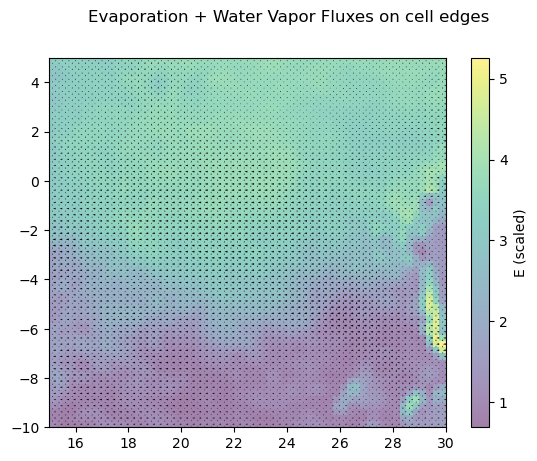

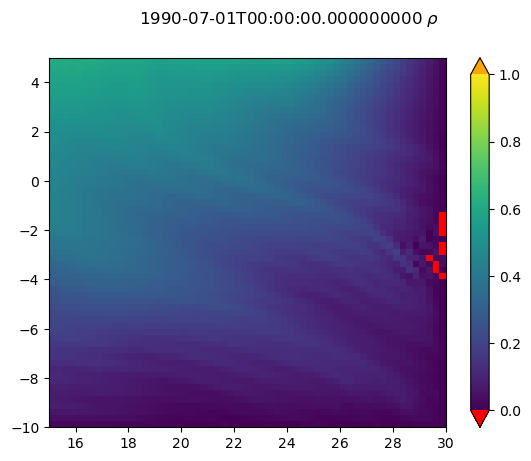

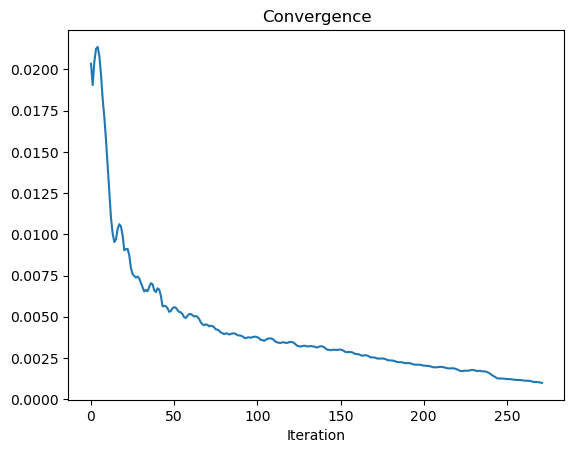

INFO:bulk_recycling_model.main:Converged in 257 iterations and 0:00:02.363188


7 1990-08-01T00:00:00.000000000
257


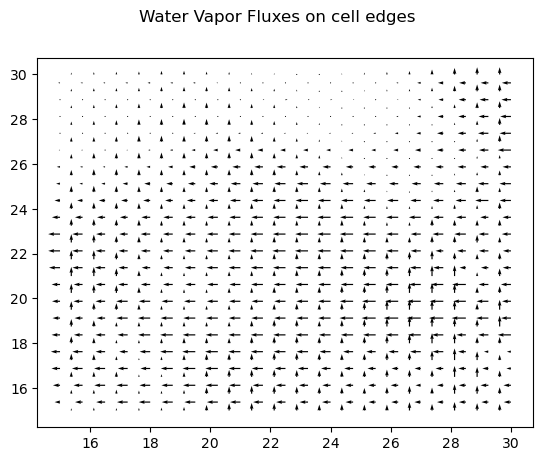

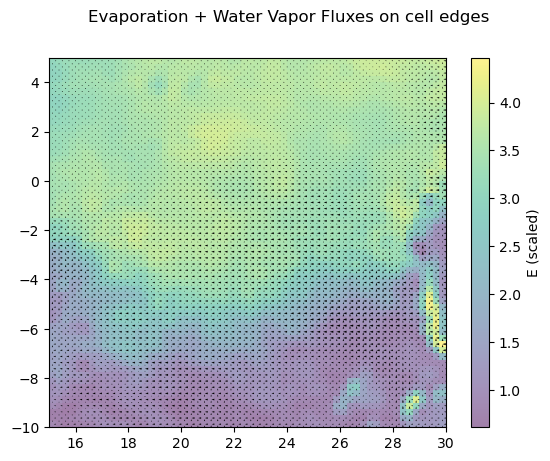

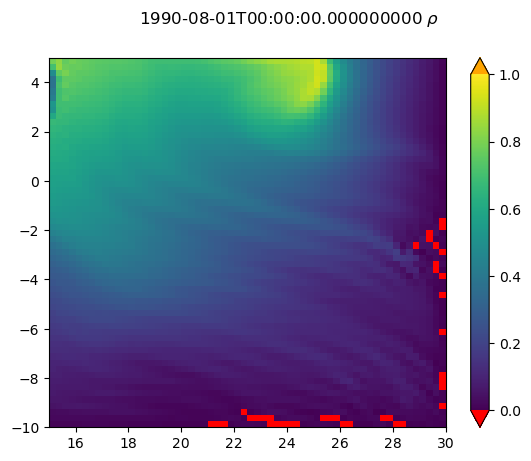

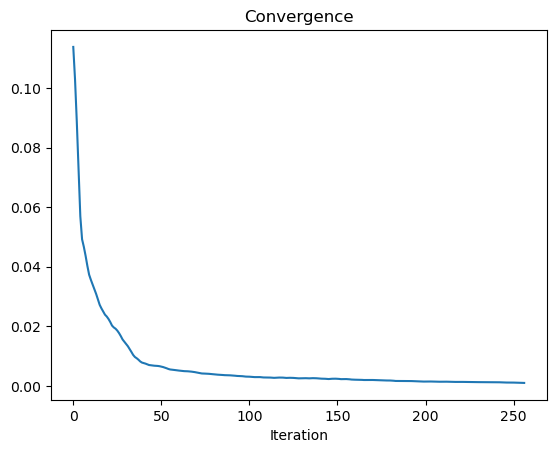

INFO:bulk_recycling_model.main:Converged in 220 iterations and 0:00:02.079551


8 1990-09-01T00:00:00.000000000
220


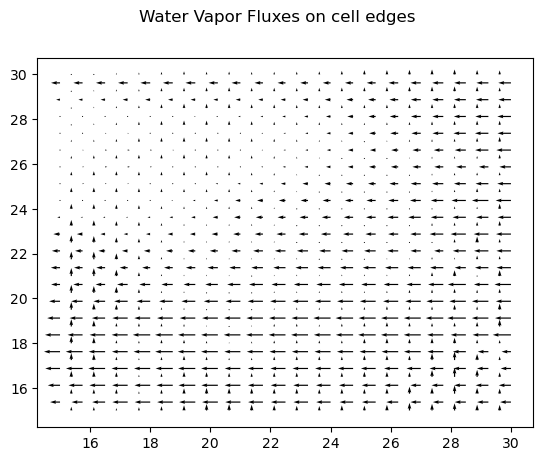

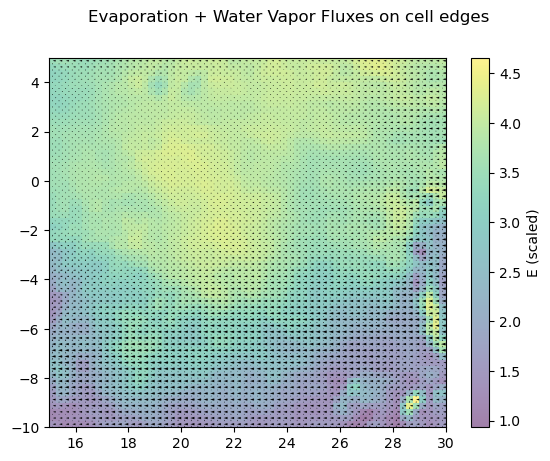

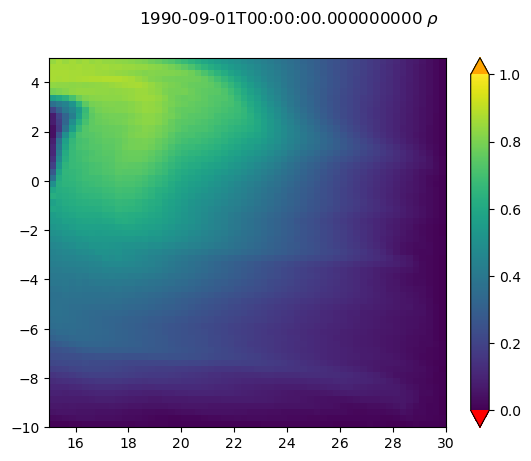

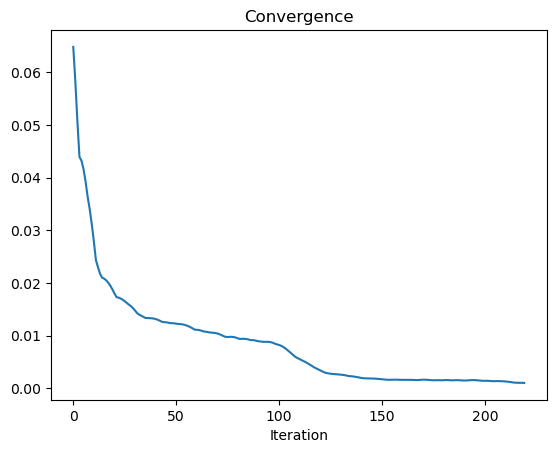

INFO:bulk_recycling_model.main:Converged in 207 iterations and 0:00:01.797747


9 1990-10-01T00:00:00.000000000
207


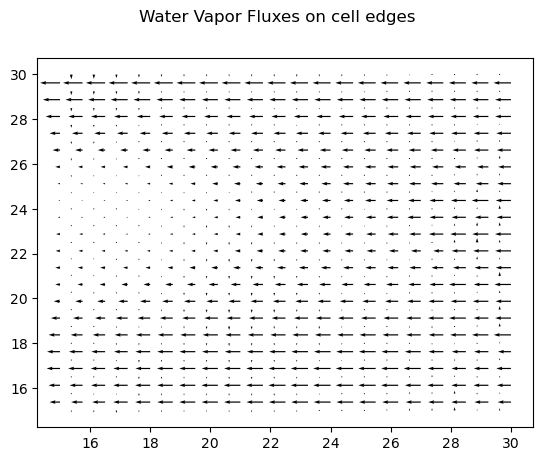

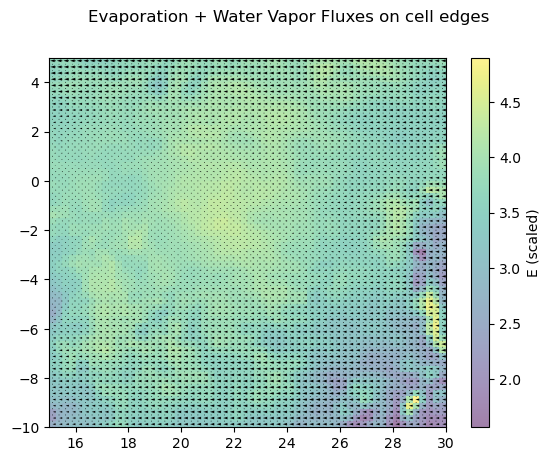

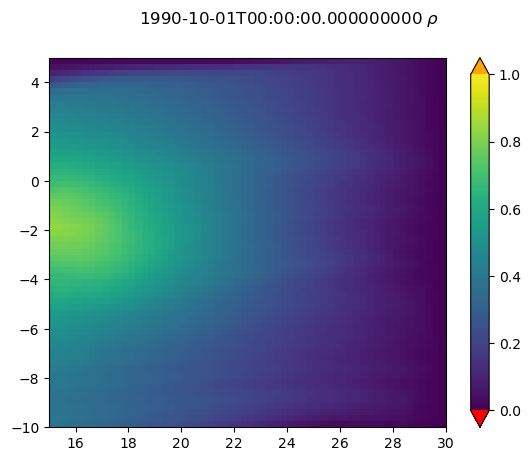

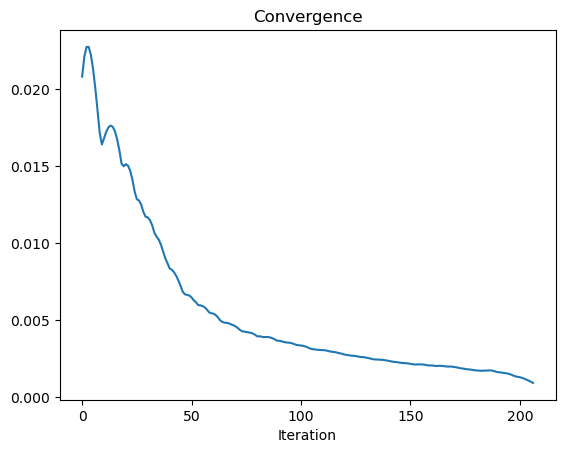

INFO:bulk_recycling_model.main:Converged in 205 iterations and 0:00:01.920723


10 1990-11-01T00:00:00.000000000
205


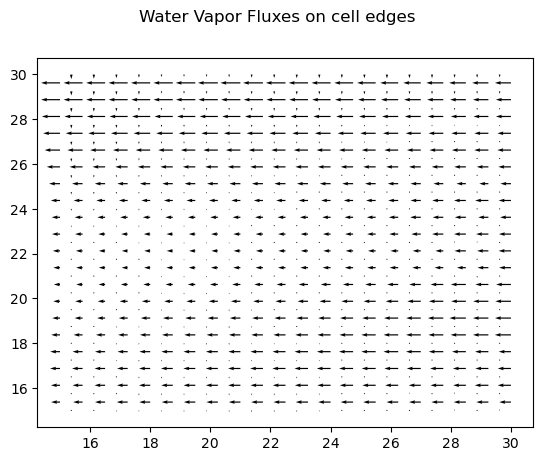

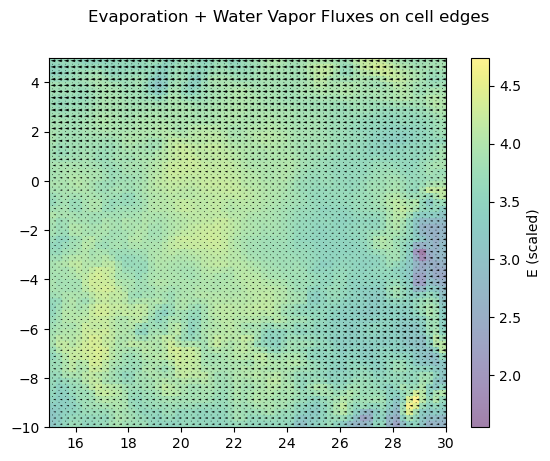

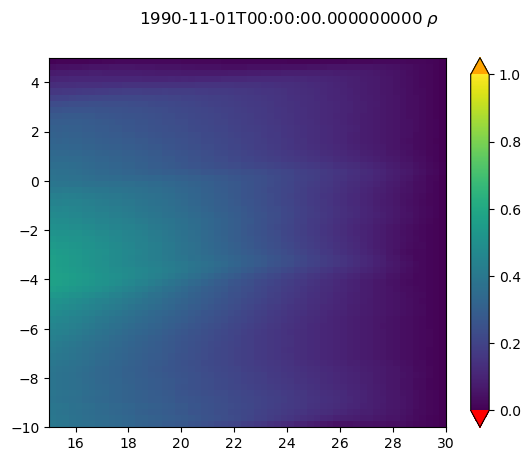

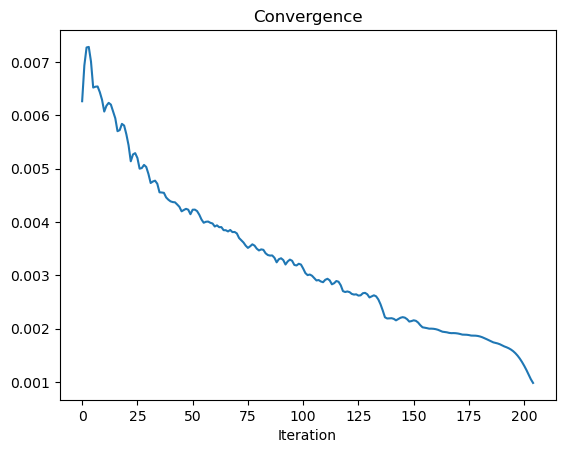

INFO:bulk_recycling_model.main:Converged in 220 iterations and 0:00:01.972250


11 1990-12-01T00:00:00.000000000
220


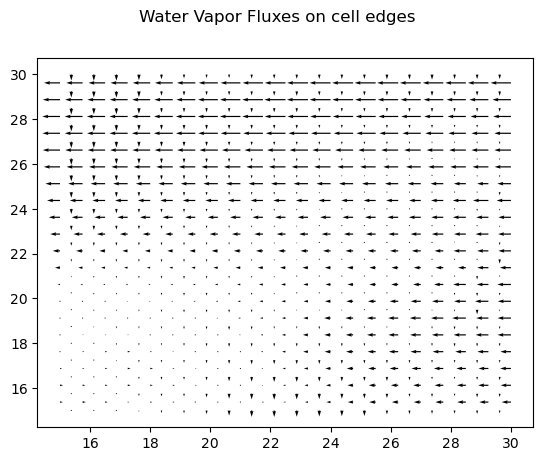

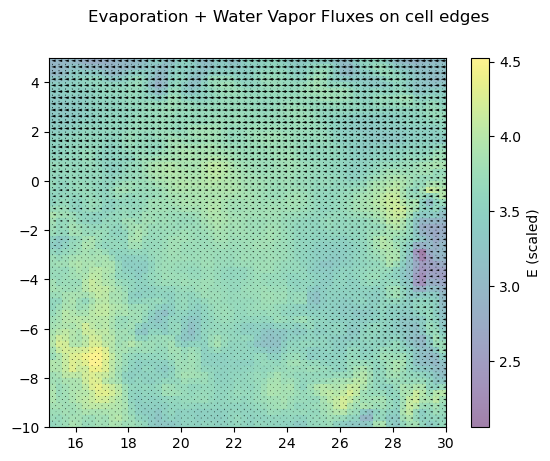

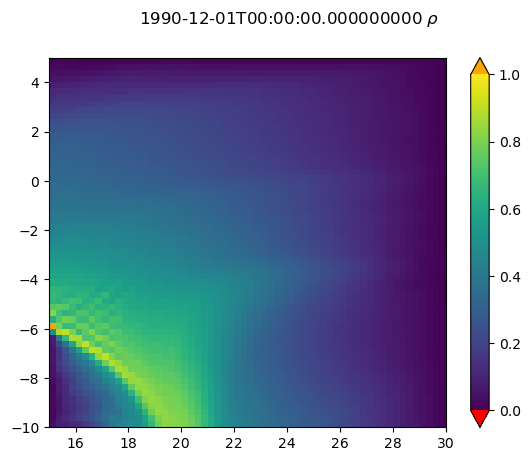

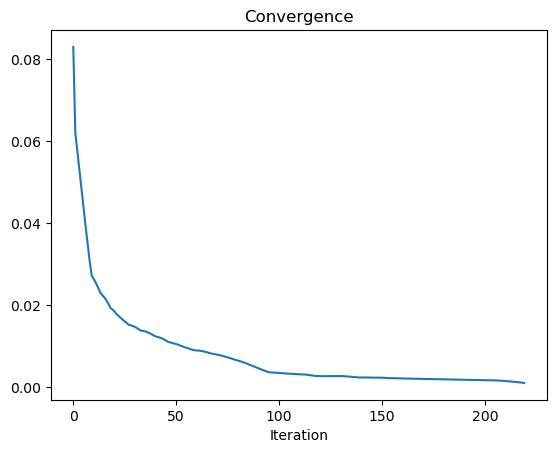

In [ ]:
import matplotlib.pyplot as plt
import logging
logging.basicConfig()
logging.getLogger("bulk_recycling_model").setLevel(logging.INFO)
from bulk_recycling_model import plotting
from bulk_recycling_model.main import run

rho_ar = np.empty((np.shape(E)[0]-1,np.shape(E)[1]-1,np.shape(E)[2]))
#Entering preprocessing and time step loop
#Run model and plot
for i,time in enumerate(ds.time):
     
    # preprocess E onto the secondary grid
    Ei = preprocess.prepare_E(E[:,:,i])
    
    # preprocess water vapor fluxes onto the secondary grid
    Fxi_left = preprocess.prepare_Fx_left(Fx[:,:,i])
    Fxi_right = preprocess.prepare_Fx_right(Fx[:,:,i])
    Fyi_bottom = preprocess.prepare_Fy_bottom(Fy[:,:,i])
    Fyi_top = preprocess.prepare_Fy_top(Fy[:,:,i])
    
    # compute P
    Pi = preprocess.calculate_precipitation(Fxi_left, Fxi_right, Fyi_bottom, Fyi_top, Ei, dx, dy)

    # Create a quiver plot
    fig, ax = plt.subplots()
    U,V = plotting.build_uv_fluxes(Fxi_left, Fxi_right, Fyi_bottom, Fyi_top)
    X, Y = np.meshgrid(lon_axis.half_step, lon_axis.half_step, indexing="ij")
    ax.quiver(X[::3, ::3],Y[::3, ::3],U[::3, ::3],V[::3, ::3])
    fig.suptitle("Water Vapor Fluxes on cell edges")
    
    # Create a quiver plot
    fig, ax = plt.subplots()
    collection = plotting.pcolormesh(ax, Ei, lon_axis, lat_axis, alpha=0.5)
    fig.colorbar(collection, label="E (scaled)")
    plotting.quiver(ax, Fxi_left, Fxi_right, Fyi_bottom, Fyi_top, lon_axis, lat_axis)
    fig.suptitle("Evaporation + Water Vapor Fluxes on cell edges")
    
    # Run the model
    status = run(
        Fxi_left,
        Fxi_right,
        Fyi_bottom,
        Fyi_top,
        Ei,
        Pi,
        dx,
        dy,
        R=0.2,
        R_1=0.2,
        max_iter=500,
        tol=1e-3,
    )

    #Print timestep and status (converged or not) and add rho to recycling ration array
    print(i,time.values)
    print(status['k'])
    rho_ar[:,:,i] = status["rho"]

    # plot each timestep 
    fig, ax = plt.subplots()
    cmap=plt.cm.viridis
    cmap.set_extremes(under='red', over='orange')
    collection = plotting.pcolormesh(ax, status["rho"], lon_axis, lat_axis,
                                     vmin=0.0, vmax=1,
                                     cmap=cmap)
    fig.colorbar(collection,extend='both')
    fig.suptitle(str(time.values)+" $\\rho$")
    #plt.savefig(datap+"rho_"+str(time.values)+".png")
    plt.show()
    plt.close()
    
    # plot the convergence
    deltas = status["deltas"]
    fig, ax = plt.subplots()
    ax.plot(deltas)
    ax.set_title("Convergence")
    ax.set_xlabel("Iteration")
    plt.show()
    plt.close()

**Create and save rho xarray file**

- Create an xarray to store all of the calculated recycling ratios that is organised in an easy to plot/interpret format
- Count number of values in array over 1 - replace all of these with 1
- Count number of negative rho values - replace all of these with zero
- Save to file

In [ ]:
lon_ar = np.linspace(start=ds.coords["lon"].min().values+lon_axis.step/2,
                     stop=ds.coords["lon"].max().values-lon_axis.step/2,
                     num=lon_axis.n_points-1)
lat_ar = np.linspace(start=ds.coords["lat"].min().values+lat_axis.step/2,
                     stop=ds.coords["lat"].max().values-lat_axis.step/2,
                     num=lat_axis.n_points-1)
rho_xarr = xr.Dataset(
    data_vars=dict(rho=(["lon","lat","time"],rho_ar)),
    coords=dict(
        lon=(["lon"], lon_ar),
        lat=(["lat"], lat_ar),
        time=(["time"],ds.time.data)
    ),
    attrs=dict(
        description="Recycling ratio",
        units="%",
    ),
) 
rho_xarr = rho_xarr.transpose("time","lat","lon")
rho_xarr.to_netcdf(datao+"rho_era5_"+str(YR)+".nc")

In [ ]:
#Filtering out outliers for plotting 

print('Number of rhos over 1: ', rho_xarr['rho'].where(rho_xarr['rho'].values>1.0).count().values)
print('Number of negative rhos: ', rho_xarr['rho'].where(rho_xarr['rho'].values<0.0).count().values)
rho_xarr = rho_xarr.where(rho_xarr['rho'].values<=1.0,1.0)
rho_xarr = rho_xarr.where(rho_xarr['rho'].values>0.0,0.0)
print('Number of rhos over 1: ', rho_xarr['rho'].where(rho_xarr['rho'].values>1.0).count().values)
print('Number of negative rhos: ', rho_xarr['rho'].where(rho_xarr['rho'].values<0.0).count().values)
end_all = timer.time()
length = end_all - start_all
print("Running the whole prep and recycling code took ", length, "seconds")


Number of rhos over 1:  2
Number of negative rhos:  70
Number of rhos over 1:  0
Number of negative rhos:  0
Running the whole prep and recycling code took  644.8041079044342 seconds


**Plotting**

Create seasonal arrays and plot these

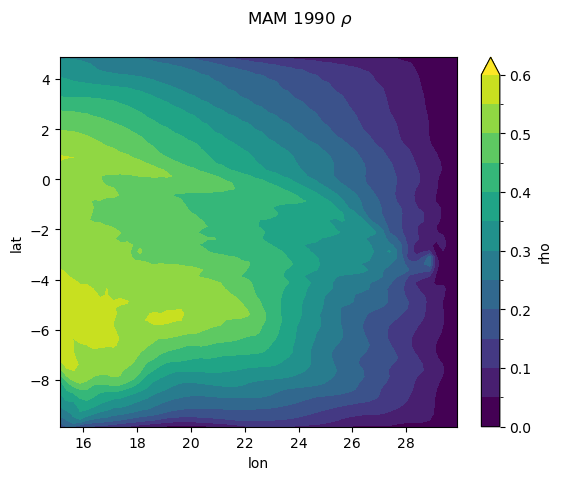

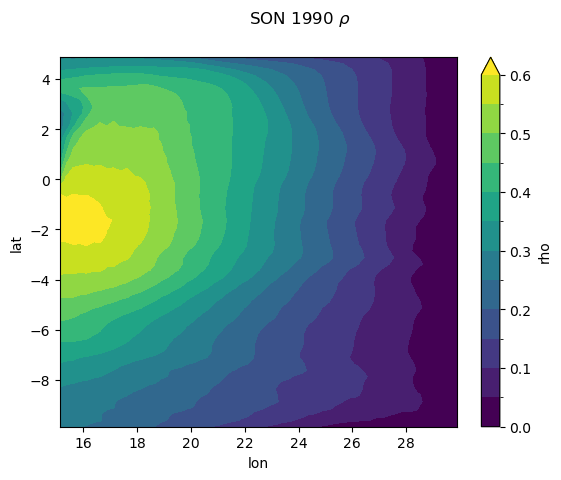

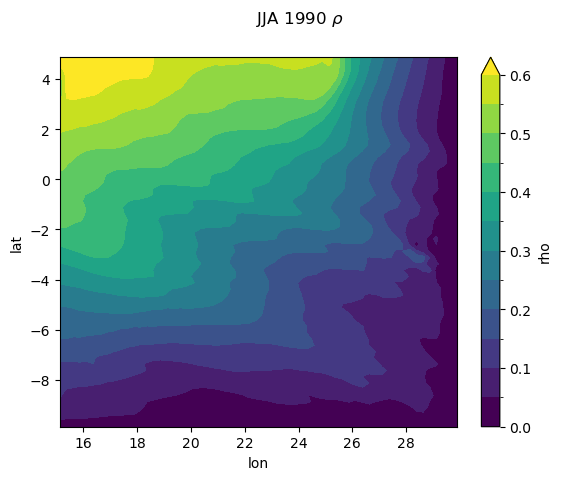

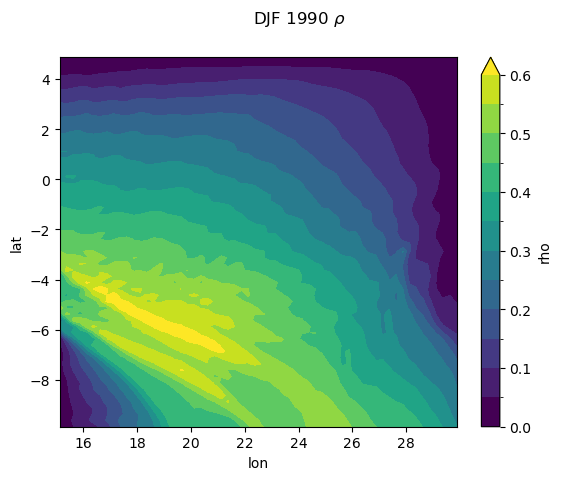

In [ ]:

mam_rho = rho_xarr['rho'].sel(time=rho_xarr.time.dt.month.isin([3,4,5]))
fig, ax = plt.subplots()
collection = mam_rho.mean("time").plot.contourf(vmin=0.0,vmax=0.6,levels=13,ax=ax,extend='max')
fig.suptitle("MAM "+str(YR)+" $\\rho$")
#plt.savefig(datao+"rho_MAM_"+str(YR)+".png")
plt.show()
    
son_rho = rho_xarr['rho'].sel(time=rho_xarr.time.dt.month.isin([9,10,11]))
fig, ax = plt.subplots()
collection = son_rho.mean("time").plot.contourf(vmin=0.0,vmax=0.6,levels=13,ax=ax,extend='max')
fig.suptitle("SON "+str(YR)+" $\\rho$")
#plt.savefig(datap+"rho_SON_"+str(YR)+".png")
plt.show()

jja_rho = rho_xarr['rho'].sel(time=rho_xarr.time.dt.month.isin([6,7,8]))
fig, ax = plt.subplots()
collection = jja_rho.mean("time").plot.contourf(vmin=0.0,vmax=0.6,levels=13,ax=ax,extend='max')
fig.suptitle("JJA "+str(YR)+" $\\rho$")
#plt.savefig(datap+"rho_JJA_"+str(YR)+".png")
plt.show()

djf_rho = rho_xarr['rho'].sel(time=rho_xarr.time.dt.month.isin([12,1,2]))
fig, ax = plt.subplots()
collection = djf_rho.mean("time").plot.contourf(vmin=0.0,vmax=0.6,levels=13,ax=ax,extend='max')
fig.suptitle("DJF "+str(YR)+" $\\rho$")
#plt.savefig(datap+"rho_DJF_"+str(YR)+".png")
plt.show()

rho_xarr.close()

